# Тестовое задание Data Analyst | Задание 5

* Тестовое задание состоит из нескольких задач, которые необходимо реализовать на языке Python.
* Допускается применение дополнительных пакетов, будет плюсом распараллелить задачи для ускорения выполнения там где это требуется.
* Все тестовые датасеты загружаем и процессим (делаем выборки, джойны, фильтруем и т.д.) в коде.
* Если у вас не получилось сделать какие-то шаги, но вы понимаете все остальное - пропускайте их и делайте то  в чем разбираетесь.
* Результат выполнения - ссылка на github с jupiter notebook. Высылаем все ответы / ссылки на fediaeva@skytecgames.com. Так же напишите сколько часов у вас ушло на выполнение.
* При возникновении вопросов по тестовому заданию - пишем туда же, на  fediaeva@skytecgames.com
* Необходимо сделать минимум 3 задания на ваш выбор. Чем больше заданий сделали, тем лучше.
* Тестовый датасет прилагается к письму sqlite файлом `testcase.db.zip`

---

## 5 Связь рекламного траффика и органического

Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.

Для выполнения задачи необходимо использовать тестовый датасет (таблица `source_comparison`).

1.	Используя Causal Impact Analysis подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее
2.	Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна

In [1]:
%%capture no-display
!pip install pycausalimpact statsmodels

In [2]:
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from causalimpact import CausalImpact

Загрузим датасет:

In [3]:
# reading data
data = pd.read_csv('source_comparison.txt')

display(data.head())
print('Data shape:', data.shape)

,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


Data shape: (18606, 4)


Приведём названия столбцов и строковые значения к нижнему регистру:

In [4]:
# bringing column names to lowercase
data.columns = [col.lower() for col in data.columns]

# lambda function to bring values to lowercase
lower_value = lambda x: x.lower()

# bringing values to lowercase 
for col in ['source_type', 'country']:
    data[col] = data[col].apply(lambda x: lower_value(x))

# checking results
data.head()

,install_dates,source_type,country,installs
0,2020-05-18,paid,py,4.0
1,2020-04-14,paid,fr,35.0
2,2020-04-30,paid,jp,25.0
3,2020-03-20,paid,de,11.0
4,2020-04-30,paid,it,8.0


Изменим тип данных в столбце с датами:

In [5]:
# changing the type of data
data['install_dates'] = pd.to_datetime(data['install_dates'])

# checking results
print('install_dates type:', data['install_dates'].dtype)

install_dates type: datetime64[ns]


Изучим данные:

In [6]:
# displaying data info
display(data.info())

# displaying data description
print('\nData description:')
display(data.describe().T)

# displaying number of NaN values in each column
print('\nTotal NaNs:')
display(data.isna().sum())

# printing total number of duplicated values
print('\nTotal duplicates:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18606 entries, 0 to 18605
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   install_dates  18606 non-null  datetime64[ns]
 1   source_type    18606 non-null  object        
 2   country        18606 non-null  object        
 3   installs       18606 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 581.6+ KB


None


Data description:


,count,mean,min,25%,50%,75%,max,std
install_dates,18606,2020-04-18 15:14:24.882296064,2020-03-18 00:00:00,2020-04-04 00:00:00,2020-04-20 00:00:00,2020-05-04 00:00:00,2020-05-18 00:00:00,NaN
installs,18606.0,51.968451,1.0,2.0,6.0,22.0,5633.0,227.810616



Total NaNs:


install_dates    0
source_type      0
country          0
installs         0
dtype: int64


Total duplicates: 679


Удалим дубликаты строк:

In [7]:
# dropping duplicated values
data = data.drop_duplicates().reset_index(drop=True)

# checking results
print('Total duplicates:', data.duplicated().sum())

Total duplicates: 0


Посмотрим на значения столбцов:

Column: INSTALL_DATES 

Total unique values: 61
Min value: 2020-03-18 00:00:00
Max value: 2020-05-18 00:00:00
Values: [Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-03-28 00:00:00'), Timestamp('2020-03-29 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-04 00:00:00'), Timestamp('2020-04-05 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-10 00:00:00'), Timestamp('2020-04-11 00:00:00'), Timestamp('2020-04-12 00:00:00'), Timestamp('2020-04-13 00:00:00'

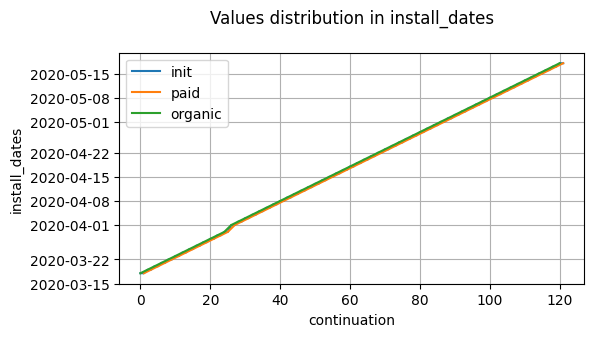


---

Column: SOURCE_TYPE 

Total unique values: 2
Min value: organic
Max value: paid
Values: ['organic', 'paid']


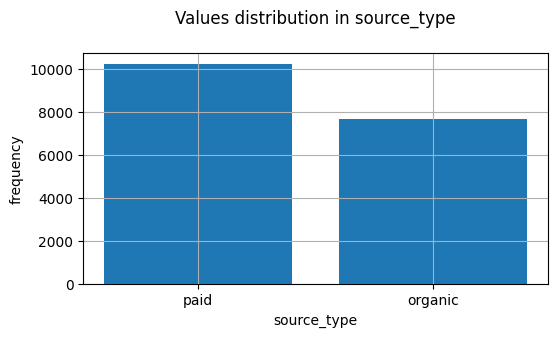


---

Column: COUNTRY 

Total unique values: 222
Min value: ad
Max value: zw
Values: ['ad', 'ae', 'af', 'ag', 'al', 'am', 'ao', 'ar', 'as', 'at', 'au', 'aw', 'ax', 'az', 'ba', 'bb', 'bd', 'be', 'bf', 'bg', 'bh', 'bi', 'bj', 'bm', 'bn', 'bo', 'bq', 'br', 'bs', 'bt', 'bw', 'by', 'bz', 'ca', 'cd', 'cf', 'cg', 'ch', 'ci', 'ck', 'cl', 'cm', 'cn', 'co', 'cr', 'cu', 'cv', 'cw', 'cy', 'cz', 'de', 'dj', 'dk', 'dm', 'do', 'dz', 'ec', 'ee', 'eg', 'es', 'et', 'eu', 'fi', 'fj', 'fm', 'fo', 'fr', 'ga', 'gb', 'gd', 'ge', 'gf', 'gg', 'gh', 'gi', 'gl', 'gm', 'gn', 'gp', 'gq', 'gr', 'gt', 'gu', 'gw', 'gy', 'hk', 'hn', 'hr', 'ht', 'hu', 'id', 'ie', 'il', 'im', 'in', 'iq', 'ir', 'is', 'it', 'je', 'jm', 'jo', 'jp', 'ke', 'kg', 'kh', 'ki', 'kn', 'kr', 'kw', 'kz', 'la', 'lb', 'lc', 'li', 'lk', 'lr', 'ls', 'lt', 'lu', 'lv', 'ly', 'ma', 'md', 'me', 'mf', 'mg', 'mh', 'mk', 'ml', 'mm', 'mn', 'mo', 'mp', 'mq', 'mr', 'mt', 'mu', 'mv', 'mw', 'mx', 'my', 'mz', 'nc', 'ne', 'ng', 'ni', 'nl', 'no', 'np', 'nr', 'nz', 'o

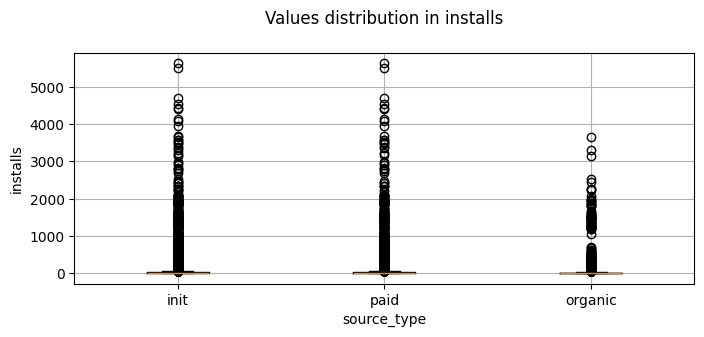


---



In [8]:
def plot_data(data: pd.DataFrame, 
              col: str, 
              col_group: str = None, 
              col_split: str = None, 
              col_agg: str = None, 
              plot_type: str = None) -> None:
    '''Plot values distribution

        Args:
        - data (pd.DataFrame) - initial data
        - col (str) - column name
        - col_group (str, optional) - column name to group data. Defaults to None
        - col_split (str, optional) - column name to split data. Defaults to None
        - col_agg (str, optional) - column name to aggregate values. Defaults to None
        - plot_type (str, optional) - type of a plot. Defaults to None

        Returns: None
    '''

    if plot_type is None:
        print('No plot_type value was passed. Define the plot_type value')
    else: 
        data_col = data[col]

        if col_group is not None and col_split is not None and col_agg is not None:
            data_col_group = data.groupby([col_group, col_split])[col_agg].sum().reset_index()
        
        if col_split is not None:
            vals_split = data[col_split].unique()

        match plot_type:
            case 'plot':
                plt.figure(figsize=(6, 3))
                plt.plot(data_col_group[col_group], label='init')

                for val in vals_split:
                    plt.plot(data_col_group[data_col_group[col_split] == val][col_group], label=val)
                
                plt.legend()

                x_label = 'continuation'
                y_label = col

            case 'bar':
                plt.figure(figsize=(6, 3))

                data_col_value_counts = data_col.value_counts()
                plt.bar(data_col_value_counts.index, data_col_value_counts.values)

                x_label = col
                y_label = 'frequency'

            case 'boxplot':
                names = ['init']
                boxes = [data_col]

                for val in vals_split:
                    names.append(val)
                    boxes.append(data[data[col_split] == val][col])
                
                fig, ax = plt.subplots(figsize=(8, 3))
                ax.boxplot(boxes, labels=names, )

                x_label = 'source_type'
                y_label = col
        
        plt.title(f'Values distribution in {col}\n')

        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.grid()
        plt.show()
    

# printing columns info
for col in data.columns:
    print('Column:', col.upper(), '\n')

    col_unique_values = data[col].unique()
    col_unique_values_sorted = sorted(col_unique_values)

    print('Total unique values:', len(col_unique_values))
    print('Min value:', min(col_unique_values_sorted))
    print('Max value:', max(col_unique_values_sorted))
    print('Values:', col_unique_values_sorted)

    if isinstance(data[col][0], datetime):
        plot_data(
            data=data, 
            col=col, 
            col_group='install_dates', 
            col_split='source_type', 
            col_agg='installs', 
            plot_type='plot'
        )
    
    if len(col_unique_values) <= 10:
        plot_data(
            data=data, 
            col=col, 
            plot_type='bar'
        )
    
    if data[col].dtype == float:
        plot_data(
            data=data, 
            col=col,  
            col_split='source_type', 
            plot_type='boxplot'
        )
    
    print('\n---\n')

Разделим данные по двум источникам с сортировков по возрастанию дат и группировкой по ним:

In [9]:
def separate_data(data: pd.DataFrame,
                  col_split: str,
                  val_split: str,
                  col_group: str,
                  col_agg: str) -> pd.DataFrame:
    '''

        Args:
        - data (pd.DataFrame) - initial data
        - col_split (str) - column name to split data
        - val_split (str) - value to split data within col_split
        - col_group (str) - column name to group by data
        - col_agg (str) - column name to aggregate grouped data within col_group

        Returns: 
        - pd.DataFrame - new data
    '''
    
    data_new = data.copy()
    data_new = data_new[data_new[col_split] == val_split]
    data_new = data_new.sort_values(by=col_group)
    data_new = data_new.groupby(col_group)[col_agg].sum()
    data_new = data_new.reset_index()

    return data_new


# separating data into new datasets
data_paid = separate_data(
    data=data, 
    col_split='source_type', 
    val_split='paid', 
    col_group='install_dates', 
    col_agg='installs'
)

data_organic = separate_data(
    data=data, 
    col_split='source_type', 
    val_split='organic', 
    col_group='install_dates', 
    col_agg='installs'
)

# checking results
display(data_paid.head())
print('data_paid shape:', data_paid.shape)

print()

display(data_organic.head())
print('data_organic shape:', data_organic.shape)

,install_dates,installs
0,2020-03-18,7339.0
1,2020-03-19,6731.0
2,2020-03-20,7243.0
3,2020-03-21,9482.0
4,2020-03-22,14751.0


data_paid shape: (61, 2)



,install_dates,installs
0,2020-03-18,8961.0
1,2020-03-19,8457.0
2,2020-03-20,8819.0
3,2020-03-21,4485.0
4,2020-03-22,5105.0


data_organic shape: (61, 2)


Объединим наборы данных по двум источникам:

In [10]:
# joining datas
data_source_type = data_paid.join(data_organic, lsuffix='_paid', rsuffix='_organic')

# removing extra column, changing columns names and setting index with dates
if sum(data_source_type['install_dates_paid'] == data_source_type['install_dates_organic']) == data_source_type.shape[0]:
    data_source_type = data_source_type.drop('install_dates_organic', axis=1)
    data_source_type.columns = ['install_dates', *data_source_type.columns[1:]]

# checking results
display(data_source_type.head())
print('data_source_type shape:', data_source_type.shape)

,install_dates,installs_paid,installs_organic
0,2020-03-18,7339.0,8961.0
1,2020-03-19,6731.0,8457.0
2,2020-03-20,7243.0,8819.0
3,2020-03-21,9482.0,4485.0
4,2020-03-22,14751.0,5105.0


data_source_type shape: (61, 3)


Проведём анализ статистик описания данных:

In [11]:
# displaying data description
pd.DataFrame(data_source_type.describe()).T

,count,mean,min,25%,50%,75%,max,std
install_dates,61,2020-04-17 18:53:06.885245952,2020-03-18 00:00:00,2020-04-03 00:00:00,2020-04-18 00:00:00,2020-05-03 00:00:00,2020-05-18 00:00:00,NaN
installs_paid,61.0,11247.639344,6411.0,9416.0,11399.0,12737.0,21769.0,2868.587272
installs_organic,61.0,4576.672131,3207.0,3858.0,4207.0,4980.0,8961.0,1228.751409


Вычислим разницу между последовательными датами:

In [12]:
# getting difference between dates
diff_data_source_type = data_source_type['install_dates'].diff().dt.days

# getting indexes with non continuation
diff_data_source_type_non_index = data_source_type[diff_data_source_type > 1].index.values

# checking results
print(diff_data_source_type.value_counts())

install_dates
1.0    59
2.0     1
Name: count, dtype: int64


Сформирует непрерывный временной ряд:

In [13]:
date_start = data['install_dates'].min()
date_end = data['install_dates'].max()

# creating range od dates
data_series = pd.DataFrame(index=(pd.date_range(start=date_start, end=date_end)))
data_series.index.name = 'install_dates'

# joining datas
data_series = data_series.join(data_source_type.set_index('install_dates'), how='left')

# checking results
display(data_series.head())
print('data_series.shape:', data_series.shape)
print('Monotonic increasing data:', data_series.index.is_monotonic_increasing)

,installs_paid,installs_organic
install_dates,,
2020-03-18,7339.0,8961.0
2020-03-19,6731.0,8457.0
2020-03-20,7243.0,8819.0
2020-03-21,9482.0,4485.0
2020-03-22,14751.0,5105.0


data_series.shape: (62, 2)
Monotonic increasing data: True


Проверим временной ряд на наличие пропущенных значений:

In [14]:
# getting rows with nan values
data_series_nan = data_series[data_series.isna().all(axis=1)]

# checking results
display(data_series_nan)
print('data_series_nan shape:', data_series_nan.shape)

,installs_paid,installs_organic
install_dates,,
2020-03-31,NaN,NaN


data_series_nan shape: (1, 2)


Построим график распределения значений в наборе данных:

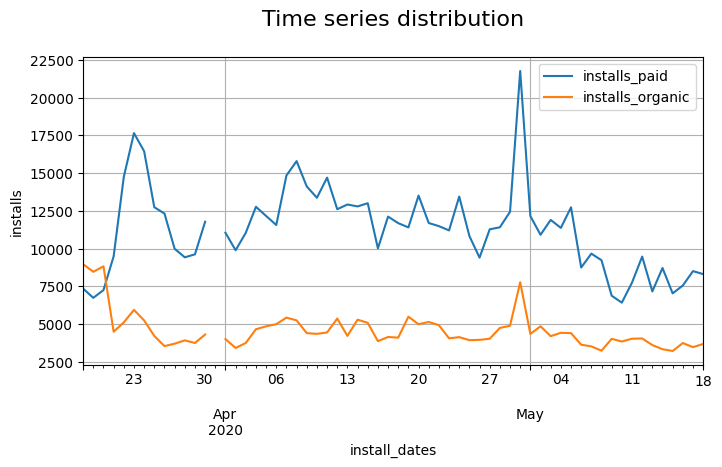

In [15]:
def plot_time_series(data: pd.DataFrame, separator = False) -> None:
    '''Plot time series data

        Args:
        - data (pd.DataFrame) - initial data
        - separator (Timeseries, optional) - value to split timeseries. Defualts to None

        Returns: None
    '''
    
    data.plot(ax=plt.gca(), figsize=(8, 4))

    if separator is not None:
        plt.axvline(x=separator, color='red')

    plt.title('Time series distribution\n', fontsize=16)
    plt.ylabel('installs')
    
    plt.grid()
    plt.show()


# plotting time series
plot_time_series(data_series)

Заполним пропуски в данных:

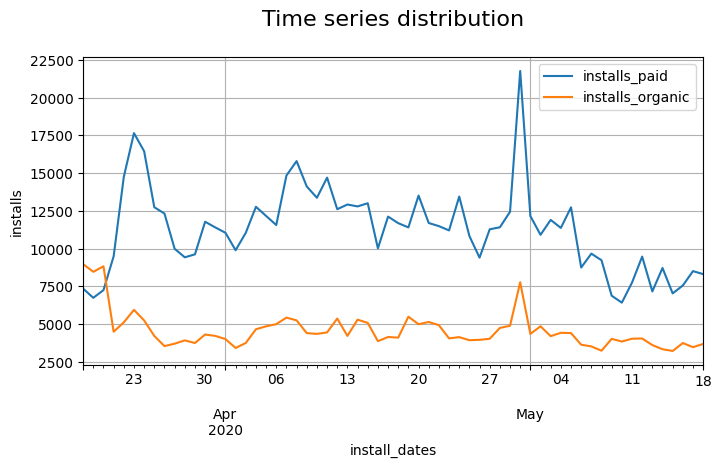

Months in data: [3, 4, 5]
Years in data: [2020]


In [16]:
# filling missing values in data
for col in data_series.columns:
    data_series[col] = data_series[col].fillna(data_series[col].median())

# checking results
plot_time_series(data_series)

print('Months in data:', list(data_series.index.month.unique()))
print('Years in data:', list(data_series.index.year.unique()))

Построим графики трендов, сезонности и шума:

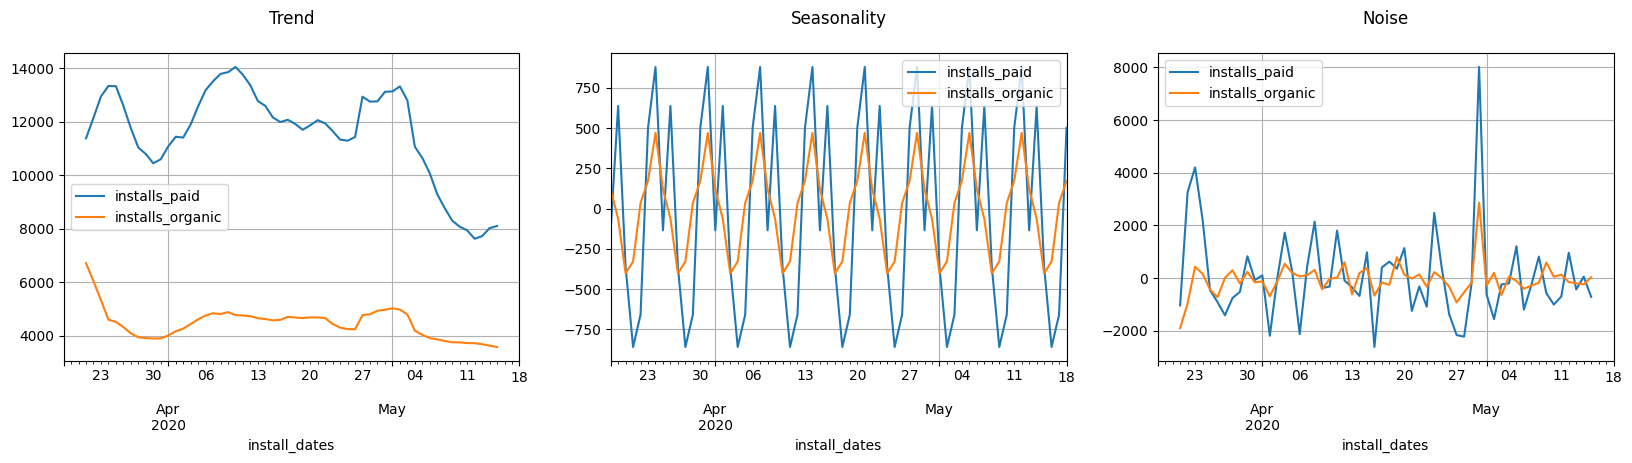

In [17]:
def plot_decomposed(data: pd.DataFrame) -> None:
    '''Plot time series trends, seasonality and noise
       
       Args:
       - data (pd.DataFrame) - initital data

       Returns: None    
    '''
    
    plt.figure(figsize=(20, 4))

    decomposed = {}
    
    for col in data.columns:
        decomposed[col] = seasonal_decompose(data[col])
    
    plt.subplot(131)
    for name, dec in decomposed.items():
        dec.trend.plot(ax=plt.gca(), label=name)
    plt.title('Trend\n')
    plt.legend()
    plt.grid()
    
    plt.subplot(132)
    for name, dec in decomposed.items():
        dec.seasonal.plot(ax=plt.gca(), label=name)
    plt.title('Seasonality\n')
    plt.legend()
    plt.grid()
    
    plt.subplot(133)
    for name, dec in decomposed.items():
        dec.resid.plot(ax=plt.gca(), label=name)
    plt.title('Noise\n')
    plt.legend()
    plt.grid()
    
    plt.show()
    

# plotting data
plot_decomposed(data_series)

Гипотезы:

* Нулевая ($ H_0 $) - Временной ряд является нестационарным.
* Альтернативная ($ H_1 $) - Временной ряд является стационарным.

In [18]:
def get_p_value(data: pd.DataFrame, col: str, alpha: float = 0.05) -> None:
    '''
       Args:
       - data (pd.DataFrame) - intitial value
       - col (str) - column name
       - alpha (float, optional) - p-value threshold. Defaults = 0.05
       
       Returns: None
    '''
    
    p_value = round(adfuller(data[col])[1], 3)

    if p_value < alpha:
        print(f'{p_value} < {alpha}\t->\tH_0 is confirmed')
    else:
        print(f'{p_value} >= {alpha}\t->\tH_0 is rejected')


get_p_value(data_series, 'installs_paid')
get_p_value(data_series, 'installs_organic')

0.028 < 0.05	->	H_0 is confirmed
0.0 < 0.05	->	H_0 is confirmed


><br>
>Временной ряд нестационарен.
><br><br>

<br>

### 5.1 Используя Causal Impact Analysis, подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу, которая кажется вам наиболее вероятной, и проверьте ее

Исходные данные для 2 потоков игроков (рекламный и органический):

install_dates | installs_paid | installs_organic
-|-|-
... | ... | ...

<br>

Гипотезы:
* Нулевая ($ H_0 $) - Привлечение большего рекламного траффика не увеличивает органический (рекламный траффик не связан с органическим)
* Альтернативная ($ H_1 $) - Привлечение большего рекламного траффика увеличивает органический (рекламный и органический траффики связаны)

Определим даты начала и окончания периодов до и после изменений (самый низкий органический траффик):

Date start: 2020-03-18 00:00:00
Date end: 2020-05-18 00:00:00
Treatment start: 2020-04-02 00:00:00

Pre period: ['2020-03-18', '2020-04-02']	->	daily average: 11113.4375
Post period: ['2020-04-03', '2020-05-18']	->	daily average: 11297.608695652174

Raw difference between pre and post treatment:	->	 184.171195652174


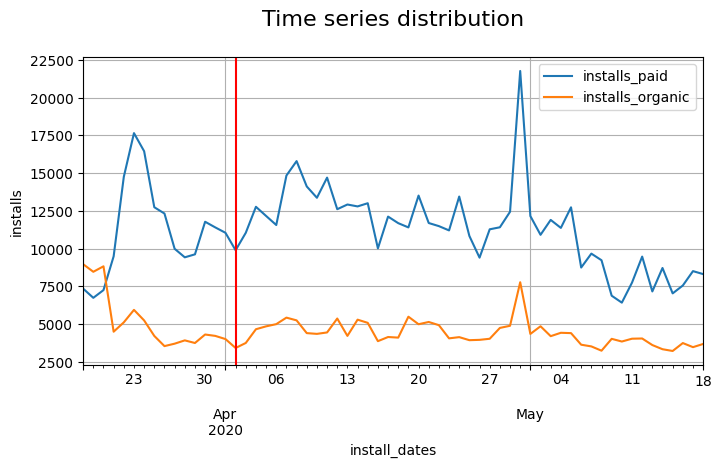

In [19]:
date_start = data_series.index.min()
date_end = data_series.index.max()
treatment_start = pd.to_datetime(data_series.index.mean().date() - timedelta(days=15))

pre_period = [str(date_start)[:10], str(treatment_start)[:10]]
post_period = [str(treatment_start + timedelta(days=1))[:10], str(date_end)[:10]]

pre_daily_avg = data_series.loc[: treatment_start, 'installs_paid'].mean()
post_daily_avg = data_series.loc[treatment_start + timedelta(days=1) :, 'installs_paid'].mean()

# checking results
print('Date start:', date_start)
print('Date end:', date_end)
print('Treatment start:', treatment_start)

print(f'\nPre period: {pre_period}\t->\tdaily average: {pre_daily_avg}')
print(f'Post period: {post_period}\t->\tdaily average: {post_daily_avg}')

print('\nRaw difference between pre and post treatment:\t->\t', post_daily_avg - pre_daily_avg)

plot_time_series(data_series, separator=treatment_start)

Проведение причинно-следственного анализа:

c:\Python 3.10.11\lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\Python 3.10.11\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


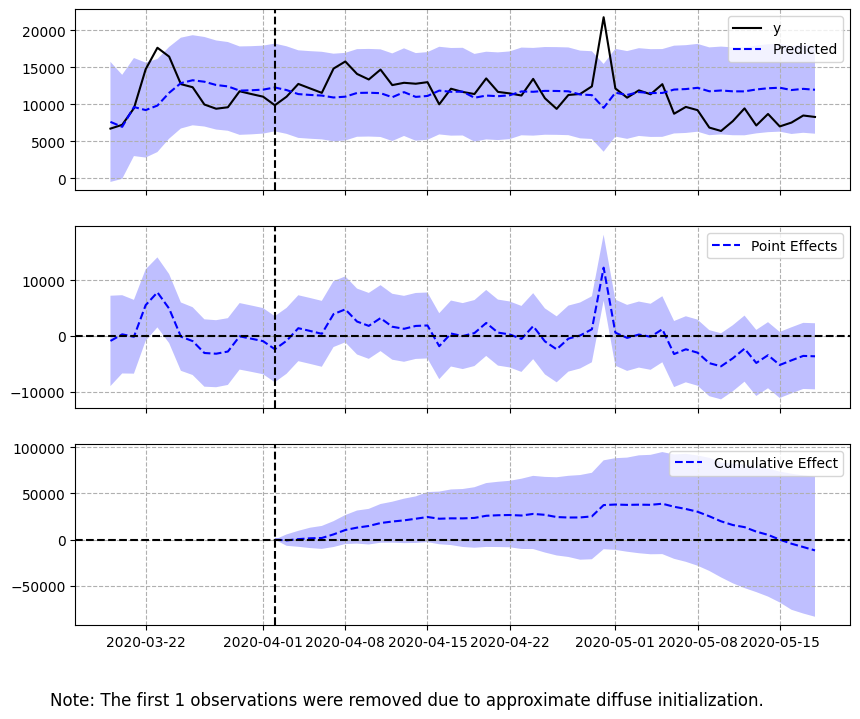

In [20]:
# analysing causal impact
impact = CausalImpact(data_series, pre_period, post_period)

# plotting results
impact.plot(figsize=(10, 8))

Выведение числовых характеристик проведённого анализа:

In [21]:
# printing summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11297.61           519690.0
Prediction (s.d.)         11552.9 (842.13)   531433.47 (38737.97)
95% CI                    [9815.38, 13116.47][451507.48, 603357.54]

Absolute effect (s.d.)    -255.29 (842.13)   -11743.47 (38737.97)
95% CI                    [-1818.86, 1482.23][-83667.54, 68182.52]

Relative effect (s.d.)    -2.21% (7.29%)     -2.21% (7.29%)
95% CI                    [-15.74%, 12.83%]  [-15.74%, 12.83%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 62.04%

For more details run the command: print(impact.summary('report'))


><br>
><b>Вывод</b>
><br>
>
>Нулевая гипотеза не подтвердилась - привлечение большего рекламного траффика увеличивает органический (рекламный и органический траффики связаны).
><br><br>

<br>

### 5.2 Количественно рассчитайте вероятность, что гипотеза маркетологов (или ваша) верна

Построение регрессии методом наименьших квадратов:

In [22]:
X = data_series['installs_paid']
Y = data_series['installs_organic']

# training model
model_ols = smf.ols(formula='Y ~ X', data=data_series)
result_ols = model_ols.fit()

# checking results
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.025
Date:                Sat, 27 Jul 2024   Prob (F-statistic):             0.0871
Time:                        18:55:52   Log-Likelihood:                -526.53
No. Observations:                  62   AIC:                             1057.
Df Residuals:                      60   BIC:                             1061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3514.1657    626.264      5.611      0.0

Построение графика с результатами работы модели:

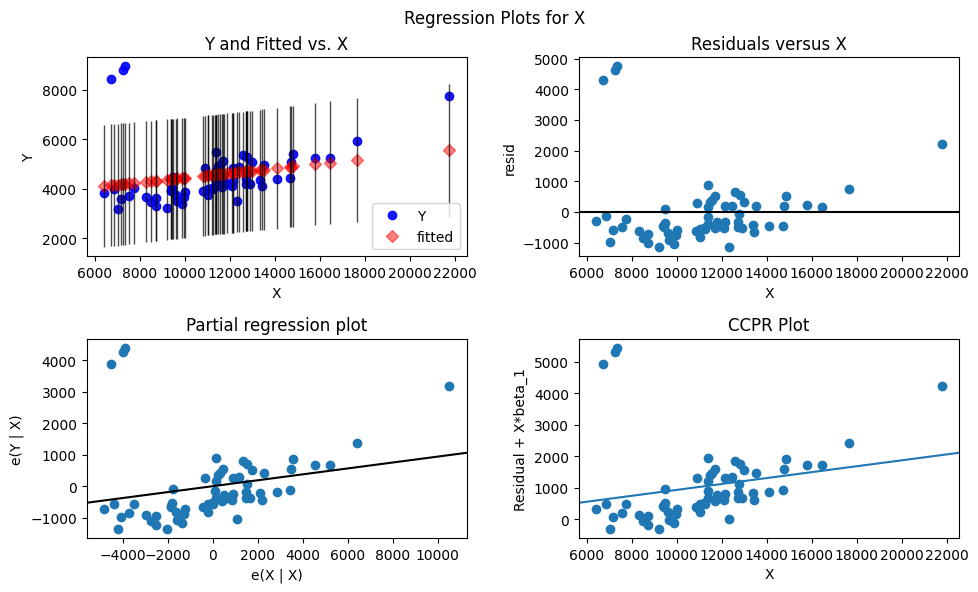

In [23]:
fig=plt.figure(figsize=(10, 6))

sm.graphics.plot_regress_exog(result_ols, 'X', fig=fig)

plt.show()

><br>
><b>Вывод</b>
><br>
>
>Нулевая гипотеза не подтвердилась - привлечение большего рекламного траффика увеличивает органический (рекламный и органический траффики связаны).
><br><br>